In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from utils import load_dataset

# Simple Neural Network with Numpy

Let's build a simple NN with [numpy](https://numpy.org/) to a binary classification task.  
**The goal** : build a cat classifier.  

For this let’s build a Logistic regression with Neural Network mindset.  
**Architecture of the Model :**
  
  ![Reg_log_NN_diagramme.svg](img/Reg_log_NN_diag.svg)


# 1. Import Data

In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

# 2. Prepare Data

In [3]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print(m_train, m_test, num_px)

209 50 64


### 2.1 Flatten Data
We have to transform the image into a vector. For that we reshape the image (64, 64, 3) to a vector (1, 64 * 64 * 3).

In [4]:
train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T
test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T
train_set_x_flatten.shape

(12288, 209)

### 2.1 Normalize Data
Let's normalize images by dividing them by 255 (the maximum value of a pixel channel).

In [5]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

# 3. Build the Model

### 3.1 Define the sigmoid function

In [6]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    return 1 / (1 + np.exp(-z))

### 3.2 Initialize parameters w, b

For this NN we can initialize parameters $w$ by 0.

In [7]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    w = np.zeros((dim, 1))
    b = 0.
    
    return w, b

### 3.3 Forward and Backward Propagation
- Compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{1}$$  
  
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{2}$$

In [8]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    # FORWARD
    # compute activation
    A = sigmoid(np.dot(w.T, X) + b)
    
    # compute cost
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    # BACKWARD
    # compute gradients
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    
    # compute cost
    cost = np.squeeze(np.array(cost))

    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### 3.4 Optimize parameters w, b

Update $w$ and $b$ to minimize the cost function $J$.
$ w := w - \alpha \ \frac{\partial J}{\partial w}\tag{3}$
  
  
$ b := b - \alpha \ \frac{\partial J}{\partial b}\tag{4}$

In [9]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        
        # Cost and gradient calculation 
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update parameters
        w = w - learning_rate * grads['dw']
        b = b - learning_rate * grads['db']
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

### 3.5 Predict the output
Calculate $\hat{Y} = A = \sigma(w^T X + b)$

In [10]:
def predict(w, b, X, threshold=.5):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0, i] > threshold:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    
    return Y_prediction

### 3.6 Merge all to buid the model

In [11]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False, threshold=.5):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    # Initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Gradient descent
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params['w']
    b = params['b']
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test, threshold)
    Y_prediction_train = predict(w, b, X_train, threshold)
    
    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

# 4. Test Model

In [12]:
model_reg_log = model(train_set_x,
                      train_set_y,
                      test_set_x,
                      test_set_y,
                      num_iterations=2000,
                      learning_rate=0.005,
                      print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


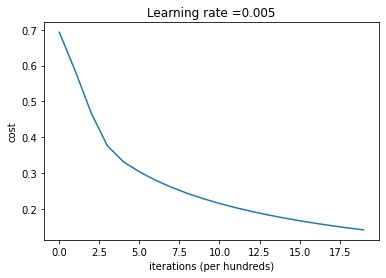

In [13]:
costs = np.squeeze(model_reg_log['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(model_reg_log["learning_rate"]))
plt.show()

# Model Constructor

In [14]:
class Log_Reg_NN():
    
    def __init__(self,
                 X_train,
                 Y_train):
        
        self.X_train = X_train
        self.Y_train = Y_train
        self.w = np.zeros((self.X_train.shape[0], 1))
        self.b = 0.
        self.costs = []
        
        
    def train(self,
              num_iterations=2000,
              learning_rate=0.005,
              print_cost=False):
        
        self.w = copy.deepcopy(self.w)
        self.b = copy.deepcopy(self.b)

        for i in range(num_iterations):
            
            # Cost and gradient calculation 
            m = self.X_train.shape[1]
            
            # FORWARD
            # compute activation
            A = sigmoid(np.dot(self.w.T, self.X_train) + self.b)

            # compute cost
            cost = (-1 / m) * np.sum(self.Y_train * np.log(A) + (1 - self.Y_train) * np.log(1 - A))
            
            # BACKWARD
            # compute gradients
            dw = (1 / m) * np.dot(self.X_train, (A - self.Y_train).T)
            db = (1 / m) * np.sum(A - self.Y_train)

            # compute cost
            cost = np.squeeze(np.array(cost))

            # update parameters
            self.w = self.w - learning_rate * dw
            self.b = self.b - learning_rate * db

            # Record the costs
            if i % 100 == 0:
                self.costs.append(cost)

                # Print the cost every 100 training iterations
                if print_cost:
                    print ("Cost after iteration %i: %f" %(i, cost))
        
        
    def predict(self, X, threshold=.5):
        
        m = X.shape[1]
        Y_prediction = np.zeros((1, m))

        # Compute vector "A" predicting the probabilities of a cat being present in the picture
        A = sigmoid(np.dot(self.w.T, X) + self.b)

        for i in range(A.shape[1]):

            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if A[0, i] > threshold:
                Y_prediction[0, i] = 1
            else:
                Y_prediction[0, i] = 0

        return Y_prediction
    
    
    def plot_loss(self):
        costs = np.squeeze(self.costs)
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.show()

In [15]:
mod = Log_Reg_NN(train_set_x, train_set_y)

In [16]:
mod.train(num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872


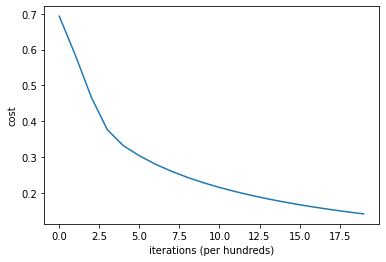

In [17]:
mod.plot_loss()